# Final Project

For my final project for DTSA 5511 I have decided to revisit the Exoplanet Classification problem I encountered doing my DTSA 5509 final project. In this notebook my aim is to implementa Deep Learning method, CNN.

https://github.com/Lorviina/MastersofScienceDataScience

In [77]:
# For numeric and data needs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [93]:
# Data
file_path = r'C:\Users\S1013521\OneDrive - Syngenta\2. Data Scientist\1. Masters of Science in Data Science\DTSA 5509 Introduction to Machine Learning\Week Six - Project\data'
exo_train = 'exoTrain.csv'
exo_test = 'exoTest.csv'

exo_train_path = os.path.join(file_path, exo_train)
exo_test_path = os.path.join(file_path, exo_test)

df_train = pd.read_csv(exo_train_path)
df_test = pd.read_csv(exo_test_path)
df_train.head()
len(df_train)
print(df_train.head())

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08  

## Deep Learning

In [109]:
from sklearn.preprocessing import StandardScaler
# Standardise
scaler = StandardScaler()

# Exclude the label column from sclaing
X_train = df_train.iloc[:, 1:].values  # Adjust this if the first column is not the label
y_train = df_train.iloc[:, 0].values   # Adjust this if the label is not in the first column

X_test = df_test.iloc[:, 1:].values    # Same adjustment as above
y_test = df_test.iloc[:, 0].values     # Same adjustment as above

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_train_scaled = pd.DataFrame(X_train_scaled, columns=df_train.columns[1:])
df_test_scaled = pd.DataFrame(X_test_scaled, columns=df_test.columns[1:])

In [111]:
print("Mean of scaled features:", np.mean(X_train_scaled, axis=0))  # Should be close to 0
print("Standard deviation of scaled features:", np.std(X_train_scaled, axis=0))  # Should be close to 1

Mean of scaled features: [-2.79356295e-18  5.58712590e-18  2.79356295e-18 ...  5.58712590e-18
  0.00000000e+00 -1.39678147e-18]
Standard deviation of scaled features: [1. 1. 1. ... 1. 1. 1.]


We need to perfrom some standardisation and feature engineering to the data. Giving each sample iin the dataset a mean of 0 and a stddev of 1. 

We apply a uniform filter to the standardised data along axis 1. Which essentially creates a moving average of the time series data with a window size of 200, helping to capture longer-term trends in the data.

In [104]:
import matplotlib.pyplot as plt

In [120]:
y_train = df_train.iloc[:, 0].values[:, np.newaxis]-1
print(y_train.shape)
y_test = df_test.iloc[:, 0].values[:, np.newaxis]-1
print(y_test.shape)

(5087, 1)
(570, 1)


In [113]:
x_train = np.stack([X_train_scaled, uniform_filter1d(X_train_scaled, axis=1, size=200)], axis=2)
x_test = np.stack([X_test_scaled, uniform_filter1d(X_test_scaled, axis=1, size=200)], axis=2)

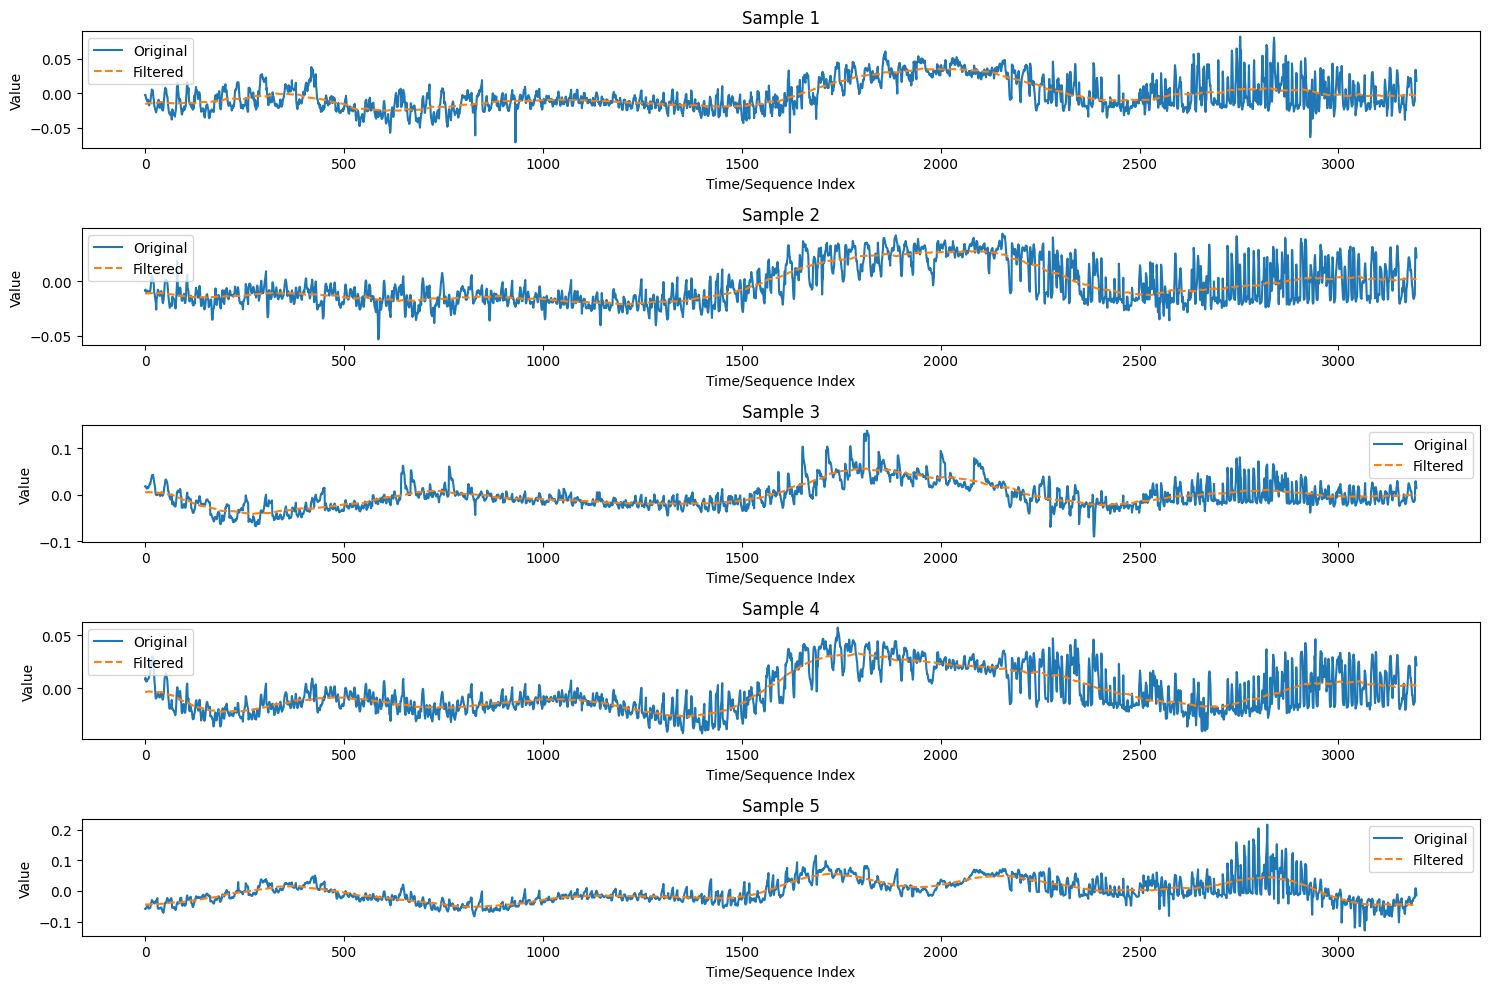

In [114]:
# Select a few samples to plot
num_samples = 5
feature_index = 0  

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(x_train[i, :, feature_index], label='Original')
    plt.plot(x_train[i, :, feature_index + 1], label='Filtered', linestyle='--')
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Time/Sequence Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
# Define the model
model = Sequential([
    # First convolutional layer
    Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(strides=4),
    
    # Second convolutional layer
    Conv1D(filters=32, kernel_size=11, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(strides=4),
    
    # Third convolutional layer
    Conv1D(filters=64, kernel_size=11, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(strides=4),
    
    # Flatten to feed into a DNN
    Flatten(),
    
    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.25),
    
    # Output layer
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification, 'softmax' if more classes
])

# Compile the model
model.compile(optimizer=Adam(1e-3),
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 3187, 16)            │             368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 3187, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 797, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 787, 32)             │           5,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 787, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 197, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 187, 64)             │          22,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 187, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 47, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 3008)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │         192,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,713 (866.07 KB)

 Trainable params: 221,489 (865.19 KB)

 Non-trainable params: 224 (896.00 B)

In [123]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Generates batches of training data with equal number of positive and negative samples,
    and applies random time rotation to each sample.

    Args:
    x_train (numpy.ndarray): Input features for training.
    y_train (numpy.ndarray): Labels for training.
    batch_size (int): Number of samples per batch.

    Yields:
    Tuple[numpy.ndarray, numpy.ndarray]: A batch of input features and labels.
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, 1), dtype='float32')  # Ensure y_batch is correctly shaped.
    
    # Indices for positive and negative samples
    yes_idx = np.where(y_train[:, 0] == 1)[0]
    non_idx = np.where(y_train[:, 0] == 0)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        # Fill the batch with half from each class
        selected_yes_idx = yes_idx[:half_batch]
        selected_non_idx = non_idx[:half_batch]  # Ensure equal number, fix from non_idx[half_batch:batch_size]

        x_batch[:half_batch] = x_train[selected_yes_idx]
        x_batch[half_batch:] = x_train[selected_non_idx]
        y_batch[:half_batch] = y_train[selected_yes_idx]
        y_batch[half_batch:] = y_train[selected_non_idx]
    
        # Apply random time rotation to each sample
        for i in range(batch_size):
            shift_amount = np.random.randint(x_train.shape[1])
            x_batch[i] = np.roll(x_batch[i], shift_amount, axis=0)
     
        yield x_batch, y_batch

In [124]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    x=batch_generator(x_train, y_train, batch_size=32),
    steps_per_epoch=x_train.shape[0] // 32,  # Number of batches per epoch
    epochs=10,
    validation_data=(x_test, y_test),  # Assuming you have validation data prepared
    verbose=1
)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5409 - loss: 0.8127 - val_accuracy: 0.9895 - val_loss: 0.3845
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6016 - loss: 0.6975 - val_accuracy: 0.0263 - val_loss: 0.7959
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5973 - loss: 0.6909 - val_accuracy: 0.0088 - val_loss: 1.6294
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6279 - loss: 0.6616 - val_accuracy: 0.0105 - val_loss: 2.5426
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6220 - loss: 0.6359 - val_accuracy: 0.0123 - val_loss: 3.2394
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6466 - loss: 0.6312 - val_accuracy: 0.0123 - val_loss: 3.1694
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6689 - loss: 0.6181 - val_accuracy: 0.0123 - val_loss: 3.6943
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6694 - loss: 0.5973 - val_accu

In [125]:
# More training
model.compile(optimizer=Adam(1e-2), loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    x=batch_generator(x_train, y_train, batch_size=32),
    steps_per_epoch=x_train.shape[1] // 32,  # Number of batches per epoch
    epochs=50,
    validation_data=(x_test, y_test),  # Assuming you have validation data prepared
    verbose=2
)

Epoch 1/50
99/99 - 3s - 31ms/step - accuracy: 0.5249 - loss: 1.8662 - val_accuracy: 0.0456 - val_loss: 1.2160
Epoch 2/50
99/99 - 2s - 16ms/step - accuracy: 0.5518 - loss: 0.7041 - val_accuracy: 0.9509 - val_loss: 0.6049
Epoch 3/50
99/99 - 2s - 16ms/step - accuracy: 0.5676 - loss: 0.6781 - val_accuracy: 0.9912 - val_loss: 0.0690
Epoch 4/50
99/99 - 2s - 16ms/step - accuracy: 0.6054 - loss: 0.6608 - val_accuracy: 0.9825 - val_loss: 0.2704
Epoch 5/50
99/99 - 2s - 16ms/step - accuracy: 0.5972 - loss: 0.6646 - val_accuracy: 0.0281 - val_loss: 0.8222
Epoch 6/50
99/99 - 2s - 15ms/step - accuracy: 0.5896 - loss: 0.6618 - val_accuracy: 0.9860 - val_loss: 0.5794
Epoch 7/50
99/99 - 2s - 16ms/step - accuracy: 0.5928 - loss: 0.6573 - val_accuracy: 0.9684 - val_loss: 0.6983
Epoch 8/50
99/99 - 2s - 16ms/step - accuracy: 0.5919 - loss: 0.6518 - val_accuracy: 0.9649 - val_loss: 0.6139
Epoch 9/50
99/99 - 2s - 15ms/step - accuracy: 0.5827 - loss: 0.6652 - val_accuracy: 0.9754 - val_loss: 0.3525
Epoch 10/5

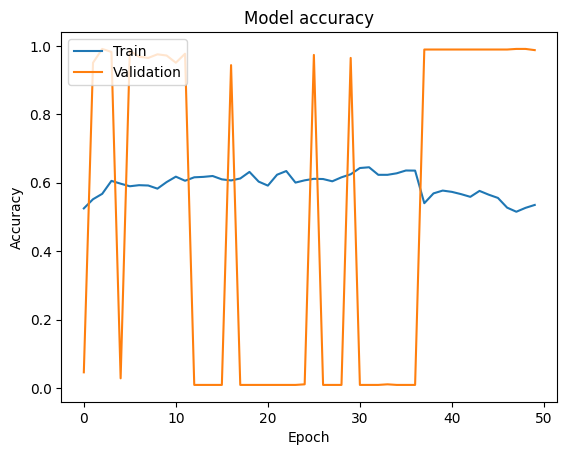

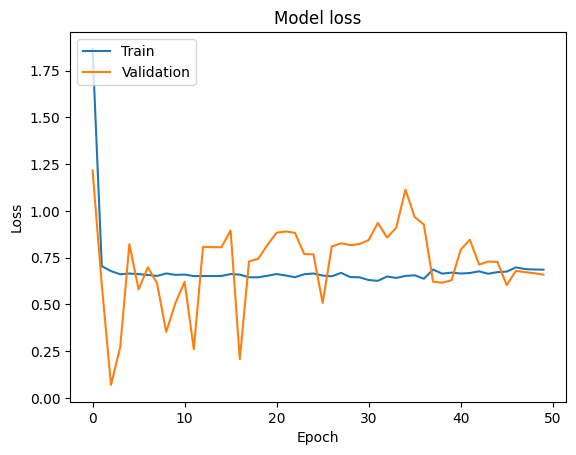

In [126]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()